[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 5.3503 - val_loss: 1.9123 - learning_rate: 0.0010
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.2226 - val_loss: 1.8016 - learning_rate: 0.0010
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 3.2110 - val_loss: 1.7157 - learning_rate: 0.0010
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.8390 - val_loss: 1.6755 - learning_rate: 0.0010
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2.6559 - val_loss: 1.5996 - learning_rate: 0.0010
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.3078 - val_loss: 1.5440 - learning_rate: 0.0010
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.1553 - val_loss: 1.5282 - learning_rate: 0.0010
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.0359 - val_loss: 1.4737 - learning_rate: 0.0010
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.8730 - val_loss: 1.4085 - learning_rate: 0.0010
Epoch 10/2

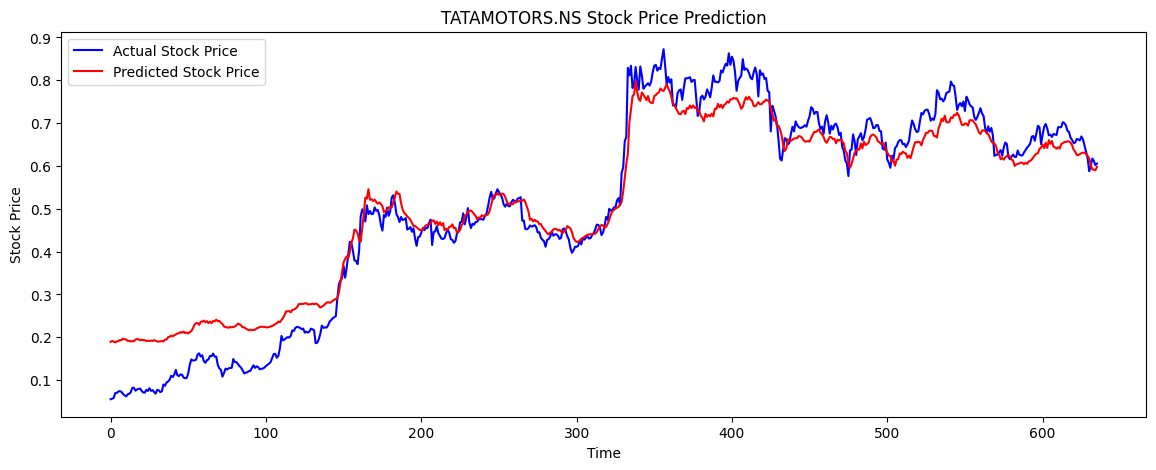

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2

# Download data for Tata Motors (TATAMOTORS.NS)
ticker = 'TATAMOTORS.NS'
data = yf.download(ticker, start="2010-01-01", end="2023-01-01")

# Feature selection ('Open', 'High', 'Low', 'Close', 'Volume')
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Data preprocessing
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 3])  # Predicting 'Close' price
    return np.array(X), np.array(y)

seq_length = 30  # Using 30 days of data to predict the next day's price
X, y = create_sequences(scaled_data, seq_length)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape X for Conv1D (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# Build the CNN model with additional complexity and regularization
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01), input_shape=(seq_length, X.shape[2])))
model.add(BatchNormalization())  # Add batch normalization
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))  # Increased dropout
model.add(Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))  # Increased units
model.add(BatchNormalization())  # Add batch normalization
model.add(Dropout(0.5))  # Another dropout layer
model.add(Dense(1))  # Predicting one value
model.compile(optimizer='adam', loss='mse')

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train the model with early stopping and learning rate scheduler
history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Predict and plot
predictions = model.predict(X_test)

# Plot the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color='blue', label='Actual Stock Price')
plt.plot(predictions, color='red', label='Predicted Stock Price')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()